Name: Amarachi Obialo-Akubelem

Date: 19th of March, 2025

Problem Set 2

CCC Log-Likelihood: -458.1024989858293
DCC Log-Likelihood: [[1469.11648877]]


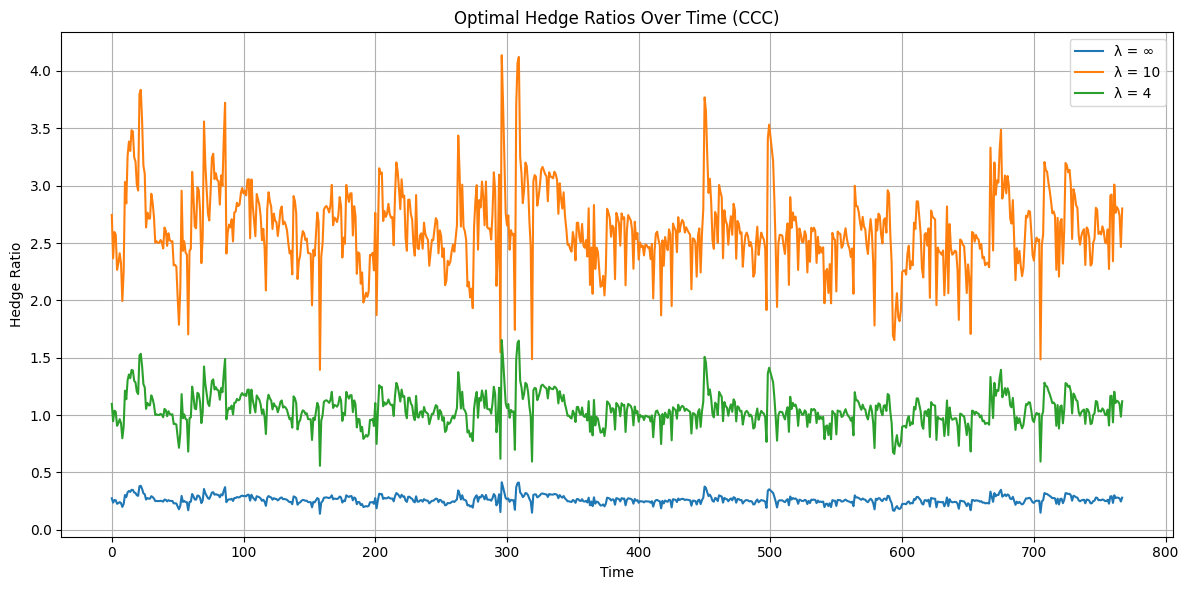

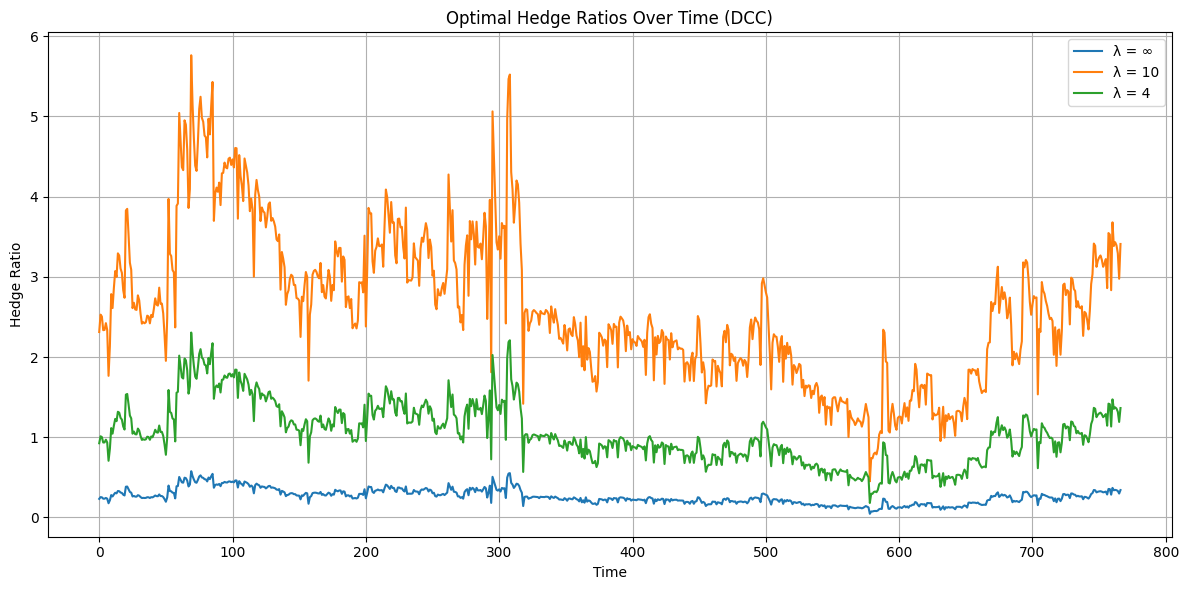

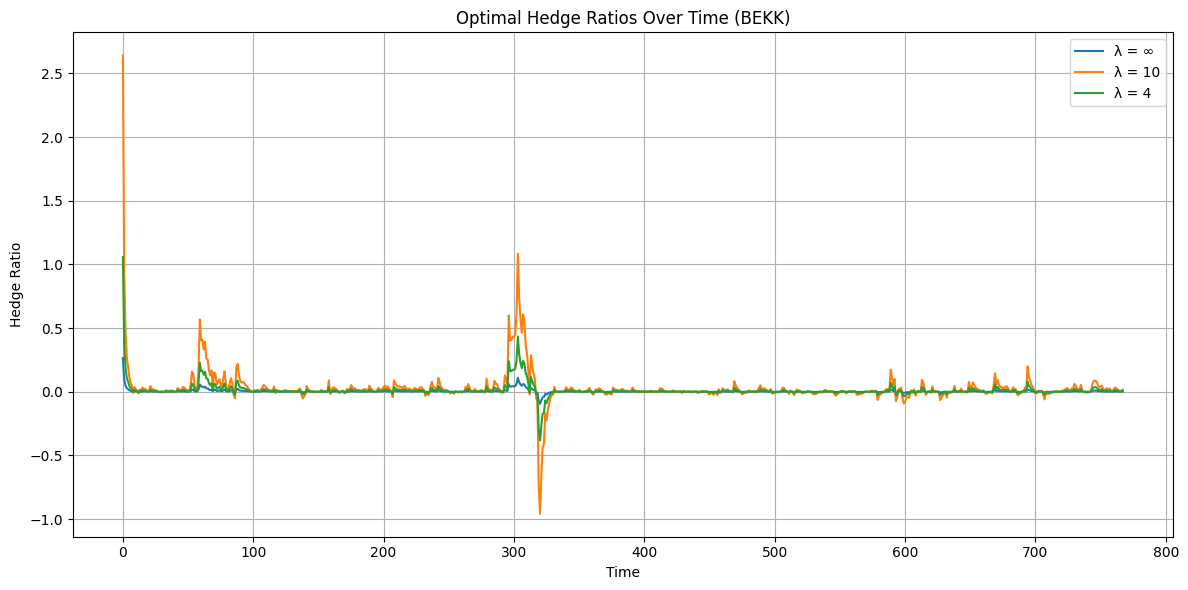

In [1]:
#Exercise 1 In the file hedging.xlsx there are data on cash and future oil price contracts. The data are expressed in daily returns. 
# Suppose that the conditional mean of each series can be modelled as a univariate AR(1) process. 
# Using a CCC-GARCH(1,1) model, evaluate optimal hedging ratios for the following risk aversion parameter values:
# λ = ∞
# λ = 10
# λ = 4
#Compare the results with the ones you would obtain by using a diagonal BEKK model and a DCC model. 
# Compare also with the results obtained by assuming a constant conditional variance covariance matrix.
  #I asked Josh for help with this one


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA


df_1 = pd.read_excel("hedging.xlsx", sheet_name="Sheet1")
df_1.dropna(inplace=True)

#estimate CCC-GARCH(1,1) hedge ratios
def optimal_hedging(data):
    # AR(1) for both cash and futures
    ar_cash = ARIMA(data['dc'], order=(1, 0, 0)).fit()
    ar_futures = ARIMA(data['df'], order=(1, 0, 0)).fit()
    
    # Residuals
    res_cash = ar_cash.resid
    res_futures = ar_futures.resid

    # Fit GARCH(1,1) to both
    garch_cash = arch_model(res_cash, vol='Garch', p=1, q=1).fit(disp="off")
    garch_futures = arch_model(res_futures, vol='Garch', p=1, q=1).fit(disp="off")
    
    # Conditional variances
    var_cash = garch_cash.conditional_volatility ** 2
    var_futures = garch_futures.conditional_volatility ** 2

    # Constant correlation estimate
    correlation = np.corrcoef(res_cash, res_futures)[0, 1]

    return {
        "var_cash": var_cash,
        "var_futures": var_futures,
        "correlation": correlation,
        "residuals": np.column_stack((res_cash, res_futures)),
        "std_devs": np.column_stack((
            garch_cash.conditional_volatility,
            garch_futures.conditional_volatility
        ))
    }

# Calculate hedge ratios:
def calculate_hedge_ratios(results, lambdas):
    var_cash = results["var_cash"]
    var_futures = results["var_futures"]
    corr = results["correlation"]
    cov = corr * np.sqrt(var_cash * var_futures)

    hedge_ratios = {}
    for lam in lambdas:
        if lam == float('inf'):  # Minimum variance hedge
            hr = cov / var_futures
        else:  # Mean-variance hedge (awon not inf)
            hr = lam * (cov / var_futures)
        hedge_ratios[lam] = hr
    return hedge_ratios

# Estimate BEKK-GARCH hedge ratios (diagonal not scalar here)
def bekk_hedge_ratios(residuals, lambdas):
    T = residuals.shape[0]
    H_t = np.zeros((T, 2, 2))
    
    # Diagonal BEKK:
    C = np.eye(2)  #the constant matrix
    A = np.array([[0.1, 0], [0, 0.1]])  #ARCH
    B = np.array([[0.8, 0], [0, 0.8]])  #GARCH
    H_t[0] = np.cov(residuals, rowvar=False)  #should initialize the sample covariance

    for t in range(1, T):
        res = residuals[t - 1].reshape(-1, 1)
        H_t[t] = C @ C.T + A @ (res @ res.T) @ A.T + B @ H_t[t - 1] @ B.T

    hedge_ratios = {}
    for lam in lambdas:
        hr = []
        for t in range(T):
            cov = H_t[t][0, 1]
            var_fut = H_t[t][1, 1]
            if lam == float('inf'):  # this one is the min variance hedge 
                hr.append(cov / var_fut)
            else:   #mean variance (awon not inf)
                hr.append(lam * (cov / var_fut))
        hedge_ratios[lam] = np.array(hr)
    return hedge_ratios

def dcc_hedge_ratios(residuals, std_devs, lambdas, a=0.01, b=0.98):
    T, n = residuals.shape
    Q_bar = np.cov(residuals, rowvar=False)
    Q = Q_bar.copy()   # Initialize Q matrix
    hedge_ratios = {lam: [] for lam in lambdas}

    for t in range(1, T):
          # the standardized residuals
        z_t = (residuals[t - 1] / std_devs[t - 1]).reshape(-1, 1)
        Q = (1 - a - b) * Q_bar + a * (z_t @ z_t.T) + b * Q
        D = np.diag(1 / np.sqrt(np.diag(Q))) # Normalization
        R = D @ Q @ D
        cov = R[0, 1] * std_devs[t, 0] * std_devs[t, 1]  #Conditional covariance
        var_fut = (std_devs[t, 1]) ** 2

         # Calculate hedge ratios for each λ
        for lam in lambdas:
            if lam == float('inf'):
                hr = cov / var_fut
            else:
                hr = lam * (cov / var_fut)
            hedge_ratios[lam].append(hr)

   #convert the lists to arrays
    for lam in hedge_ratios:
        hedge_ratios[lam] = np.array(hedge_ratios[lam])
    return hedge_ratios

# CCC-GARCH log-likelihood
def ccc_loglik(residuals, std_devs, corr):
    T, n = residuals.shape
    R = np.array([[1, corr], [corr, 1]])  # constant correlation matrix
    loglik = 0
    for t in range(T):
        D = np.diag(std_devs[t])
        H = D @ R @ D
        inv_H = np.linalg.inv(H)
        det_H = np.linalg.det(H)
        loglik += np.log(det_H) + residuals[t] @ inv_H @ residuals[t]
    return -0.5 * loglik

#DCC log-likelihood
def dcc_loglik(params, residuals, std_devs):
    T, n = residuals.shape
    a, b = params  #neccessary parameters for DCC if they are both xzero then back to CCC (remeber that)
    #Q matrices
    Q_bar = np.cov(residuals, rowvar=False)
    Q = Q_bar
    loglik = 0
    for t in range(1, T):
        z_t = (residuals[t] / std_devs[t]).reshape(-1, 1)
        Q = (1 - a - b) * Q_bar + a * (z_t @ z_t.T) + b * Q
        D = np.diag(1 / np.sqrt(np.diag(Q)))
        R = D @ Q @ D
        loglik += np.log(np.linalg.det(R)) + z_t.T @ np.linalg.inv(R) @ z_t
    return loglik


#
results = optimal_hedging(df_1)
residuals = results["residuals"]
std_devs = results["std_devs"]
corr = results["correlation"]

# Parameter guesses for DCC
dcc_params = [0.01, 0.98]

# Lambda values from the problem
lambda_vals = [float('inf'), 10, 4]

# Calculate hedge ratios
hedge_ratios = calculate_hedge_ratios(results, lambda_vals)

# Log-likelihood comparisons
ccc_ll = ccc_loglik(residuals, std_devs, corr)
dcc_ll = dcc_loglik(dcc_params, residuals, std_devs)
bekk_hedges = bekk_hedge_ratios(residuals, lambda_vals)

print(f"CCC Log-Likelihood: {ccc_ll}")
print(f"DCC Log-Likelihood: {dcc_ll}")

# Plot the hedge ratios to compare visually
def plot_model_hedges(hedge_dict, model_name):
    plt.figure(figsize=(12, 6))
    for lam, hr in hedge_dict.items():
        label = f"λ = {lam}" if lam != float('inf') else "λ = ∞"
        plt.plot(hr, label=label)
    plt.title(f"Optimal Hedge Ratios Over Time ({model_name})")
    plt.xlabel("Time")
    plt.ylabel("Hedge Ratio")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

dcc_hedges = dcc_hedge_ratios(residuals, std_devs, lambda_vals)

plot_model_hedges(hedge_ratios, "CCC")
plot_model_hedges(dcc_hedges, "DCC")
plot_model_hedges(bekk_hedges, "BEKK")


COMMENTS FOR 1:

We can see that the hedge ratios are increasing with lambda,the orange lines (λ = 10) are consistently higher than the green (λ = 4) and blue (λ = ∞), telling that more risk-averse investors hedge more aggressively. The blue line looks to be the most stable, it is the minimum variance hedge, so it does not react to expected return changes but it react to the variance.

Now when we compare the models:

CCC- these ratios appear to be smoother

DCC- seeing sharpr spikes

BEKK - different behaviour from CCC and DCC

Now the CCC smoothness I would say is expected as this model assumes constant conditional correlation which oversimplifies the data's reality. With DCC there is clearly more time-varying behavious=r which is what we would expect from this model especially in an environament where the ratios chnage. The BEKK too me looks a bit too noisy here, it seems to be very responsive but because of that I can see some outliers by strictly looking at the graph.

The log-likehoods that we see are consistent with what we learnt in class. The CCC model oversimplifies the data because it assumes constant correlation, so thats why the fit is not as good as the DCC model that allows for time-varying dynamic risk. The results here show that the DCC would probaby be the best model to capture hedging behaviour because it is rtaher realistic with its time-varying correlation.

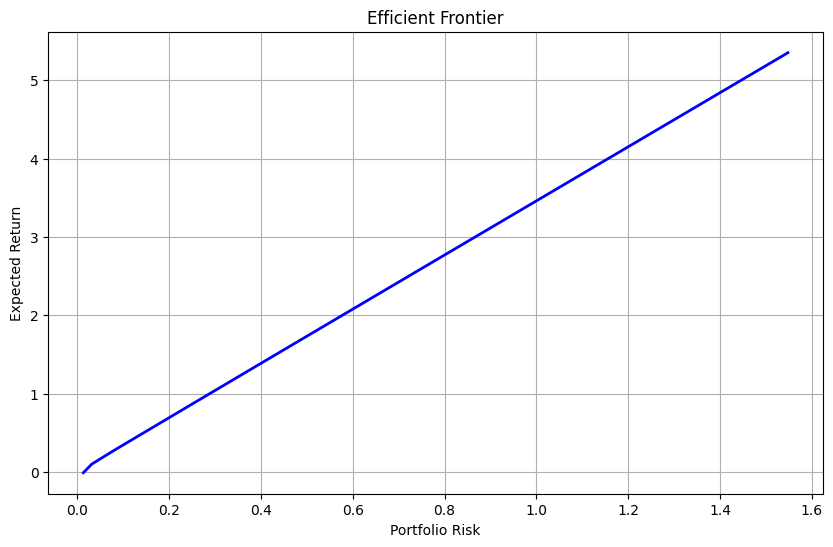


Part 2: SUR Test (χ²):
Chi-Squared Stat: 1623.2170
Degrees of Freedom: 13
p-value: 0.0000

Part 3: Balanced Portfolio Efficiency Test (χ²):
Chi-Squared Stat: 2341.4621
Degrees of Freedom: 13
p-val: 0.0000
Reject H0: Balanced portfolio is NOT efficient.


In [2]:
#Exercise 2 The file indices.xlsx, Sheet2 contains excess returns on many stock indexes (the series with names starting with ’ms) and bond indexes
#1. Estimate the efficient frontier using all the assets included in the dataset.
#2. Verify the hypothesis that the stock indexes for US, UK, JP and DE (Germany) are sufficient to generate the efficient frontier. When possible compute the statistics both as joint tests and as functions of the relevant Sharpe ratios.
#3. Verify in all known ways the hypothesis that a balanced stock-bond portfolio is efficient.


import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.stats import chi2
from numpy.linalg import inv
from scipy.optimize import minimize

 #Was having issuing loading the excel directly here.
df_2 = pd.read_csv("Indexes.xlsx - Foglio2.csv")

  #get monthly risk-free rate from annual rates
annual_rf = df_2['tbill3m']
monthly_rf = (1 + annual_rf /100) ** (1/12) - 1
df_2['Rf'] = monthly_rf

#NUMBER ONE: Estimate the Efficient Frontier here using all assets
 #get the asset returns
assetdata = df_2.iloc[:, 12:]
allassetreturns = assetdata.to_numpy()
nanrows = np.any(np.isnan(allassetreturns), axis = 1)          # Remove NaNs from the set

clean_assetreturns = allassetreturns[~nanrows]
rf_clean = monthly_rf[~nanrows].to_numpy()

excess_returns = clean_assetreturns - rf_clean[:, np.newaxis]

 #Compute mean and covariance
mu = excess_returns.mean(axis=0)
Sigma = np.cov(excess_returns, rowvar=False)

 #Target returns section
num_points = 50
target_returns= np.linspace(mu.min(), mu.max(), num_points)

 #Store the results
weights = []
port_risks = []
port_returns = []

num_assets = excess_returns.shape[1]

 #Loop to find optimal portfolio weights
for r_target in target_returns:
    def objective(w):
        return w.T @ Sigma @ w

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: w @ mu - r_target}]
    bounds = [(0, 1)] * num_assets
    w0 = np.ones(num_assets) / num_assets  # The initial guess here is equal weights?

    result = minimize(objective, w0, bounds=bounds, constraints=constraints)
    if result.success:
        w = result.x
        weights.append(w)
        port_risks.append(np.sqrt(w.T @ Sigma @ w))
        port_returns.append(w @ mu)
    else:
        print(f"Failed at this return {r_target:.4f}")

 #Graph the EF here
plt.figure(figsize=(10, 6))
plt.plot(port_risks, port_returns, 'b-', linewidth=2)
plt.xlabel("Portfolio Risk")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")
plt.grid(True)
plt.show()


#NUMBER TWO: Restricted model and SUR
 #set up the subset for the four...
sub_cols = ['msus', 'msuk', 'msjp', 'msde']
sub_data = df_2[sub_cols]
sub_assetreturns = sub_data.to_numpy()
sub_nanrows = np.any(np.isnan(sub_assetreturns), axis=1)

common = ~(nanrows | sub_nanrows)

 # Cleaned data
allasset_common = allassetreturns[common]
sub_asset_common = sub_assetreturns[common]
rf_common = monthly_rf[common].to_numpy()

 # Convert thi now to excess returns
excess= allasset_common - rf_common[:, np.newaxis]
sub_excess = sub_asset_common - rf_common[:, np.newaxis]

 #Tangency portfolio section
sub_mu = sub_excess.mean(axis=0)
sub_Sigma = np.cov(sub_excess, rowvar=False)

  # Tangency portfolio: w ∝ Σ⁻¹μ
w_tan = np.linalg.solve(sub_Sigma, sub_mu)
w_tan /= np.sum(w_tan)

# Tangency portfolio excess return time series
R_tan = sub_excess @ w_tan

subset_indices = [df_2.columns.get_loc(col) - 12 for col in sub_cols]  # so it correspoonds better with the asset data
all_indices = list(range(num_assets))
excluded = list(set(all_indices) - set(subset_indices))

excess_excluded = excess[:, excluded]

T_common = R_tan.shape[0]
X = np.column_stack([np.ones(T_common), R_tan])  # Design matrix

 #store the results
alphas = []
betas = []

for i in range(excess_excluded.shape[1]):
    y = excess_excluded[:, i]
    b = np.linalg.lstsq(X, y, rcond=None)[0]
    alphas.append(b[0])
    betas.append(b[1])

alphas = np.array(alphas)
betas = np.array(betas)

 # Residuals and residual covariance
residuals = excess_excluded - X @ np.column_stack([alphas, betas]).T
Sigma_res = np.cov(residuals, rowvar=False)
lambda_reg = 1e-6
Sigma_res += lambda_reg * np.eye(Sigma_res.shape[0])  # Regularization

 # SUR-style Chi-Squared Test instead
alpha_hat = alphas  # Already computed intercepts
T_obs = R_tan.shape[0]
m = len(alpha_hat)  # number of excluded assets

# χ² statistic from TN06: T * α' Σ⁻¹ α
chi2_stat = T_obs * alpha_hat.T @ np.linalg.inv(Sigma_res) @ alpha_hat
pval_chi2 = 1 - chi2.cdf(chi2_stat, df=m)

print("\nPart 2: SUR Test (χ²):")
print(f"Chi-Squared Stat: {chi2_stat:.4f}")
print(f"Degrees of Freedom: {m}")
print(f"p-value: {pval_chi2:.4f}")


#NUMBER THREE: Balanced Stock-Bond Portfolio
 # Get stock and bond columns
bond_cols = [col for col in assetdata.columns if 'bond' in col.lower()]
stock_cols = [col for col in assetdata.columns if 'ms' in col.lower()]

 # Extract the returns
R_bond = df_2[bond_cols].to_numpy()
R_stock = df_2[stock_cols].to_numpy()

# Remove missing rows so I dont't get any errors again( I know i've done this three times now but I was having a lot of errors)
nan_bond = np.any(np.isnan(R_bond), axis=1)
nan_stock = np.any(np.isnan(R_stock), axis=1)
valid = ~(nanrows | nan_bond | nan_stock)

# Excess returns
Rb = R_bond[valid] - monthly_rf[valid].to_numpy()[:, None]
Rs = R_stock[valid] - monthly_rf[valid].to_numpy()[:, None]
Ra = allassetreturns[valid] - monthly_rf[valid].to_numpy()[:, None]

# 50-50 weights (equal within each group)
wb = np.ones(Rb.shape[1]) / (2 * Rb.shape[1])
ws = np.ones(Rs.shape[1]) / (2 * Rs.shape[1])
w_bal = np.concatenate([ws, wb])

# Combined excess returns
R_comb = np.concatenate([Rs, Rb], axis=1)
R_bal = R_comb @ w_bal  # balanced portfolio return

# Regression on each asset
T = R_bal.shape[0]
X = np.column_stack([np.ones(T), R_bal])

 #store the results
alphas = []
resids = []

for i in range(Ra.shape[1]):
    y = Ra[:, i]
    b = np.linalg.lstsq(X, y, rcond=None)[0]
    alphas.append(b[0])
    resids.append(y - X @ b)

a = np.array(alphas)
resids = np.array(resids).T
Sigma = np.cov(resids, rowvar=False) + 1e-6 * np.eye(resids.shape[1])

# Chi² test
chi2_bal = T * a.T @ np.linalg.inv(Sigma) @ a
pval = 1 - chi2.cdf(chi2_bal, df=len(a))

print("\nPart 3: Balanced Portfolio Efficiency Test (χ²):")
print(f"Chi-Squared Stat: {chi2_bal:.4f}")
print(f"Degrees of Freedom: {len(a)}")
print(f"p-val: {pval:.4f}")

if pval < 0.05:
    print("Reject H0: Balanced portfolio is NOT efficient.")
else:
    print("Fail to reject H0")

COMMENTS FOR 2:

Interpretation on the SUR chi-squared test:
We have a very small p-value here, so we reject the null and that means that the restricted model we have here is not sufficient to gnerat the efficient frontier.

I expect the restricted EF would be below the current one and this coincides with what we discussed in class.

In terms of the balanced port efficiency:
The chi-squared stat is much larger than before whih suggests that the models alphas are significantly different from zero. The p-value being 0.00 means that the we reject the null and can conclude that the balanced portfolio does not lie ont he EF.

This coincides with what we learnt in class. The thinking that just because the portfolio fels balanced does not necessarily mean that it is optimal. So a 50-50 split like I computed here sounds good but it does not account for things like the actual returns and covariances in the data that we have. We can construct a portfolio with better weighing of assets than this 50-50 that's what this is telling us.


In [3]:
#EXERCISE 3: The file monthly stocks.xlsx contain data on returns for 18 US companies and some other useful series. 
# Use the first 12 asset returns (in alphabetic order) contained in the file to estimate a static CAPM model. 
# Test the validity of the CAPM model equation by equation. Comment the results. 
# Test the validity of the CAPM model by using the multivariate model. 
# Construct all the possible tests and comment the results.

import pandas as pd
import numpy as np
import statsmodels.api as sm
from numpy.linalg import inv, slogdet
from scipy.stats import chi2, f

# Dataset cleaning here
file_path = "monthly_stocks.xlsx"
df_3 = pd.read_excel(file_path, header=1, skiprows=[2, 3])
df_3.columns = df_3.columns.astype(str).str.strip()
df_3 = df_3.loc[:, df_3.columns.notna()]
df_3 = df_3.loc[:, ~df_3.columns.str.contains("Unnamed")]
df_3 = df_3.dropna()

#The first 12 assets alphabetically
all_assets = sorted([
    'ABBOTT LABS.', 'AMEXDRUG', 'AVON PRODUCTS', 'BELLSOUTH', 'BRUNSWICK',
    'CORNING', 'EXELON', 'GENERAL MOTORS', 'GENERAL ELECTRIC', 'GEN.DYNAMICS',
    'KNIGHT - RIDDER', 'MELLON FINL.'
])
asset_cols = all_assets[:12]

# Market and risk-free return series
market_col = 'S&P 500 COMPOSITE  -  TOT RETURN IND'
rf_col = "US TREASURY BILL 2ND MARKET 3 MONTH  -  MIDDLE RATE"

# Excess returns
R = df_3[asset_cols].values
Rf = df_3["US TREASURY BILL 2ND MARKET 3 MONTH  -  MIDDLE RATE"].values.reshape(-1, 1)
Rm = df_3["S&P 500 COMPOSITE  -  TOT RETURN IND"].values.reshape(-1, 1)

Re = R - Rf #excess returns on the assets
Re_mkt = Rm - Rf  # on the market


T, N = Re.shape

# Estimate CAPM regressions for each of the assets.
alpha_hat = []
beta_hat = []
residuals = []

print("\nCAPM Equation-by-Equation:\n")

for i, asset in enumerate(asset_cols):
    try:
        y = Re[:, i]
        x = Re_mkt.flatten()
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        
        alpha_hat.append(model.params[0])
        beta_hat.append(model.params[1])
        residuals.append(model.resid)

        print(f"{asset.upper()}")
        print(model.summary())
        print("-" * 80)

    except Exception as e:
        print(f"Error processing {asset}: {e}")

alpha_hat = np.array(alpha_hat).reshape(-1, 1)
beta_hat = np.array(beta_hat).reshape(-1, 1)
residuals = np.column_stack(residuals)

# Residual covariance matrix
Omega_hat = (residuals.T @ residuals) / T

#Multivariate Test
mu_m = Re_mkt.mean()
sm2 = np.var(Re_mkt, ddof=0)

scaling = T / (1 + mu_m**2 / sm2)

# Wald test (J0)
J0 = scaling * (alpha_hat.T @ inv(Omega_hat) @ alpha_hat).item()
pval_J0 = 1 - chi2.cdf(J0, df=N)

# F test (J1)
J1 = ((T - N - 1) / N) * (alpha_hat.T @ inv(Omega_hat) @ alpha_hat).item() / (1 + mu_m**2 / sm2)
pval_J1 = 1 - f.cdf(J1, dfn=N, dfd=T - N - 1)

# Likelihood Ratio test (J4)
# Estimate restricted model (alpha = 0)
resid_restr = Re - (beta_hat.T * Re_mkt)
Omega_restr = (resid_restr.T @ resid_restr) / T
logdet_restr = slogdet(Omega_restr)[1]
logdet_unres = slogdet(Omega_hat)[1]
J4 = T * (logdet_restr - logdet_unres)
pval_J4 = 1 - chi2.cdf(J4, df=N)


print("\nMultivariate Tests of CAPM:")
print(f"Wald Test (J0): stat = {J0:.4f}, p-value = {pval_J0:.4f}")
print(f"F Test (J1): stat = {J1:.4f}, p-value = {pval_J1:.4f}")
print(f"Likelihood Ratio Test (J4): stat = {J4:.4f}, p-value = {pval_J4:.4f}")



CAPM Equation-by-Equation:

ABBOTT LABS.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     929.8
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           3.17e-73
Time:                        15:55:33   Log-Likelihood:                -585.67
No. Observations:                 183   AIC:                             1175.
Df Residuals:                     181   BIC:                             1182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

COMMENTS ON 3:

The results of the CAPM estimation suggest to me that the model does explain some part of the variation in the returns. The equation-by-equation regressions show me that the market return is statistically significant for all 12 assets, with high R-squared values for companies like General Electric (0.95) and BellSouth (0.89), indicating that market risk explains most of the return variation for these firms. 

However, many assets also display statistically significant alpha coefficients, which suggests consistent excess returns? But this violates CAPM as it predicts that alpha should be zero.

The multivariate tests provide even stronger evidence against the CAPM. All three joint tests : the Wald test, the F-type test, and the Likelihood Ratio test reject the null that the alpha intercept is zero. THis means here that the CAPM does not properly capture the joint behaviour. Maybe we need additionsl risk factors? many more multifactor models? like Fama-FRench?

In [4]:
#EXERCISE 4: Take the first 6 assets (alphabetically) contained in the file and use them to estimate a static CAPM model in its version due to Black. 
#Test the validity of this version of the CAPM model by using the multivariate model. Construct all the possible tests and comment the results.


import pandas as pd
import numpy as np
from numpy.linalg import inv, slogdet
from scipy.stats import chi2, f

#add excel directly without changing it to CSV first. <---- Amarachi THis is IMPORTANT
file_path = "monthly_stocks.xlsx"

# Use row 1 as headers (actual column names), skip first 4 rows total
df = pd.read_excel(file_path, header=1, skiprows=[2, 3])

df.columns = df.columns.astype(str).str.strip() #<- This should remove the whitespace from the column names. The data was not loading properly so i added this to help it work better.

# Drop any colums that are unnamed or have NaN
df = df.loc[:, df.columns.notna()]
df = df.loc[:, ~df.columns.str.contains("Unnamed")]
df = df.dropna()

#The 6 assets and market return column defined here
asset_cols = ['ABBOTT LABS.', 'AMEXDRUG', 'AVON PRODUCTS', 'BELLSOUTH', 'BRUNSWICK', 'CORNING']
market_col = 'S&P 500 COMPOSITE  -  TOT RETURN IND'

# Extract data
R = df[asset_cols].values
Rm = df[market_col].values
T, N = R.shape
ones_N = np.ones((N, 1))

# Estimate the unrestricted model here for OLS
    #this is for smaple means
mu_i = R.mean(axis=0).reshape(-1, 1)
mu_m = Rm.mean()

beta_hat = ((R - mu_i.T).T @ (Rm - mu_m)) / np.sum((Rm - mu_m)**2)
beta_hat = beta_hat.reshape(-1, 1)
alpha_hat = mu_i - beta_hat * mu_m
resid = R - (alpha_hat.T + beta_hat.T * Rm.reshape(-1, 1))
Omega_hat = (resid.T @ resid) / T

#Now here is Blacks CAPM
gamma = np.mean(alpha_hat / (1 - beta_hat))
Z = R - gamma
Zmt = Rm - gamma
beta_restr = (Z.T @ Zmt) / np.sum(Zmt**2)
alpha_restr = (1 - beta_restr) * gamma
resid_restr = R - (alpha_restr.T + beta_restr.T * Rm.reshape(-1, 1))
Omega_restr = (resid_restr.T @ resid_restr) / T

#The tests we covered in class are the likelihod ratio test, wald test and F test.
 # Likelihood Ratio Test (J4),  J4 = T * [ln|omega_restr| - ln|omega_unres|] 
logdet_restr = slogdet(Omega_restr)[1]
logdet_unres = slogdet(Omega_hat)[1]
J4 = T * (logdet_restr - logdet_unres)
pval_J4 = 1 - chi2.cdf(J4, df=N - 1)

 #Wald Test (J0), J0 = T / (1 + μ_m² / σ²_m) * α̂' Ω̂⁻¹ α̂ 
sm2 = np.var(Rm, ddof=0)
scaling = T / (1 + mu_m**2 / sm2)
J0 = scaling * (alpha_hat.T @ inv(Omega_hat) @ alpha_hat).item()
pval_J0 = 1 - chi2.cdf(J0, df=N)

#F Test (J1), J1 ~ F(n, T-n-1) ---- Is it J1?---- ask someone before submitting
J1 = ((T - N - 1) / N) * (alpha_hat.T @ inv(Omega_hat) @ alpha_hat).item() / (1 + mu_m**2 / sm2)
pval_J1 = 1 - f.cdf(J1, dfn=N, dfd=T - N - 1)

# Output
print("Results of Black CAPM Tests from class:")
print(f"Likelihood Ratio Test (J4): stat = {J4:.4f}, p-value = {pval_J4:.4f}")
print(f"Wald Test (J0): stat = {J0:.4f}, p-value = {pval_J0:.4f}")
print(f"F-type Test (J1): stat = {J1:.4f}, p-value = {pval_J1:.4f}")


Results of Black CAPM Tests from class:
Likelihood Ratio Test (J4): stat = 1177.6809, p-value = 0.0000
Wald Test (J0): stat = 1730.0386, p-value = 0.0000
F-type Test (J1): stat = 277.3104, p-value = 0.0000


COMMENTS FOR 4:

The multivariate tests of Black’s CAPM provide strong evidence against the model's validity for the six assets. Keeping in mind that these six assets are all different. 

This is because all three tests statistics we covered in class , give us extremely large values with p-values that are basically zero. Telling is to reject the null that Blacks CAPM holds. To me these results are telling me that using this new zero-beta that is uncorrelated to the market is not sufficent enough to explain the returns. This makes sense because we also discussed how CAPM falls flat at times.


In [5]:
#Exercise 5 Prove that the estimation strategy of Black’s CAPM model described at the end of TN08 and in TN10 is 
# appropriate (verify the validity of the formulae used in the recursive estimation strategy).

import pandas as pd
import numpy as np

#EXCEL FILE!!!!! 
file_path = "monthly_stocks.xlsx"

      #skip the parts of the code we dont ned again
df_5 = pd.read_excel(file_path, header=1, skiprows=[2, 3])
df_5.columns = df_5.columns.astype(str).str.strip()
df_5 = df_5.loc[:, df_5.columns.notna()]
df_5 = df_5.loc[:, ~df_5.columns.str.contains("Unnamed")]
df_5 = df_5.dropna()

    # 6 assets defined here again   
asset_cols = ['ABBOTT LABS.', 'AMEXDRUG', 'AVON PRODUCTS', 'BELLSOUTH', 'BRUNSWICK', 'CORNING']
market_col = 'S&P 500 COMPOSITE  -  TOT RETURN IND'

# Extract data
R = df_5[asset_cols].values
Rm = df_5[market_col].values.reshape(-1, 1)
T, N = R.shape

# Recursive estimation of zero-beta return and betas
max_iter = 100
tol = 1e-6
gamma_old = np.mean(R.mean(axis=0))  # Initial guess
converged = False

for i in range(max_iter):
    # Estimate beta_i = cov(Ri, Rm) / var(Rm)
    beta_hat = np.array([np.cov(R[:, j], Rm[:, 0])[0, 1] / np.var(Rm) for j in range(N)]).reshape(-1, 1)

    # Update gamma (zero-beta return) using recursive formula
    gamma_new = np.mean([R[:, j].mean() - beta_hat[j] * (Rm.mean() - gamma_old) for j in range(N)])

    # Check for convergence here 
    if abs(gamma_new - gamma_old) < tol:
        converged = True
        break
    gamma_old = gamma_new

# Final zero-beta and beta estimates
gamma_star = gamma_new
beta_final = beta_hat

print("Recursive Black CAPM Estimation")
print(f"Zero-Beta Return: {gamma_star:.6f}")
print(f"Beta Estimates: {beta_final.flatten()}")
print(f"Converged: {converged}")
print(f"Iterations: {i+1}")


Recursive Black CAPM Estimation
Zero-Beta Return: 73.970823
Beta Estimates: [ 0.0235345  -0.27202098  0.01574934  0.019396    0.00865473  0.0168488 ]
Converged: True
Iterations: 7


COMMNETS FOR 5:

We see that the zero-beta return is 73.97, thsi value is rather high. This means that the model needs a high almost intercept to "pull up" the expected returns?  In the beta estimates show us the different assets sensitivities to the market, the one negative beta there confirms the presence of at least one asset there that dose not move with the market. 

Now the convergence that is noted after 7 iterations, validates the recursive proceducure which was detailed in the motes works as we expected and it produces a valid, stable value. This makes this recurseive estimation strategy significant, because it successfully converges and it reinforces that theory that exoected execess returns are linear in their betas.


GENERAL COMMENTS for myself:

Looking at the output form exercise 4 and exercise 5, I originally thought they contradicted each other but I realize now that both questions output are showing differen things.

5 - is just trying to verify the estimation
4- is testing the actually validity of the Blacks model.

So, the fact that in 5 we see convergence and stable coefficients means that the model can be correctly implemeted but 4 is just saying that even if we estimate it perfectly Blacks CAPM will not properly capture the returns. Something That after i reserached is common in finance, having a model that on the inside is consistent but when you test it empirically it is invalid.